# # Task 1: Fine-tuning BERT untuk Klasifikasi Emosi
# ## Dataset: Go Emotions dari HuggingFace
# 
# ### Deskripsi:
# - Dataset: `go_emotions` dari Google Research
# - Model: BERT-base-uncased
# - Task: Multi-label text classification
# - Label: 28 emosi berbeda

# ## 1. Instalasi dan Import Library


In [4]:
!pip install transformers datasets evaluate scikit-learn torch accelerate -q

# %%
# Import library
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers dan Datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import evaluate

# Sklearn untuk evaluasi
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report,
    multilabel_confusion_matrix
)
from sklearn.preprocessing import MultiLabelBinarizer

# Set random seed untuk reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\ASUS\Documents\UAS DL\bert_env_new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# ## 2. Load Dataset Go Emotions

Loading Go Emotions dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
Contoh data train:
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}

Jumlah data train: 43410
Jumlah data validation: 5426
Jumlah data test: 5427
Jumlah label emosi: 28

Daftar label:
 0. admiration
 1. amusement
 2. anger
 3. annoyance
 4. approval
 5. caring
 6. confusion
 7. curiosity
 8. desire
 9. disappointment
10. disapproval
11. disgust
12. embarrassment
13. excitement
14. fear
15. gratitude
16. grief
17. joy
18. love
19. nervousness
20. optimism
21. pride
22. realization
23. relief
24. remorse
25. sadness
26. surprise
27. neutral
Statistik jumlah label per sampel:
Train 

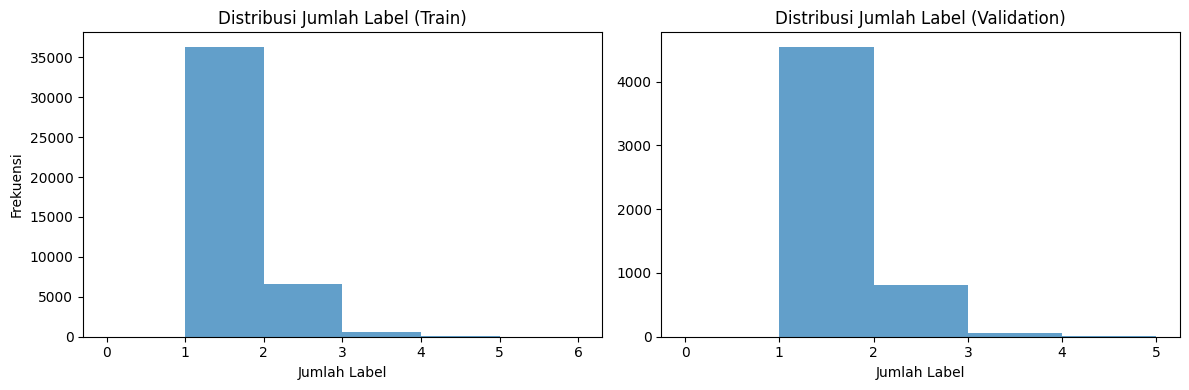

In [5]:
from datasets import load_dataset

# Load dataset dari HuggingFace
print("Loading Go Emotions dataset...")
dataset = load_dataset("go_emotions")

# Lihat struktur dataset
print("\nDataset structure:")
print(dataset)

# %%
# Lihat contoh data
print("Contoh data train:")
print(dataset['train'][0])
print(f"\nJumlah data train: {len(dataset['train'])}")
print(f"Jumlah data validation: {len(dataset['validation'])}")
print(f"Jumlah data test: {len(dataset['test'])}")

# %%
# Eksplorasi label
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

print(f"Jumlah label emosi: {len(emotion_labels)}")
print("\nDaftar label:")
for i, label in enumerate(emotion_labels):
    print(f"{i:2d}. {label}")

# %%
# Analisis distribusi multi-label
def count_labels(sample):
    return len([l for l in sample['labels'] if l < len(emotion_labels)])

# Hitung jumlah label per sampel
train_label_counts = [count_labels(sample) for sample in dataset['train']]
val_label_counts = [count_labels(sample) for sample in dataset['validation']]

print("Statistik jumlah label per sampel:")
print(f"Train - Rata-rata: {np.mean(train_label_counts):.2f}, Maks: {max(train_label_counts)}")
print(f"Val   - Rata-rata: {np.mean(val_label_counts):.2f}, Maks: {max(val_label_counts)}")

# Plot distribusi
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(train_label_counts, bins=range(0, max(train_label_counts)+2), alpha=0.7)
axes[0].set_title('Distribusi Jumlah Label (Train)')
axes[0].set_xlabel('Jumlah Label')
axes[0].set_ylabel('Frekuensi')

axes[1].hist(val_label_counts, bins=range(0, max(val_label_counts)+2), alpha=0.7)
axes[1].set_title('Distribusi Jumlah Label (Validation)')
axes[1].set_xlabel('Jumlah Label')
plt.tight_layout()
plt.show()

# ## 3. Preprocessing dan Tokenisasi


In [6]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# %%
# Fungsi untuk preprocessing
def preprocess_function(examples):
    # Tokenisasi teks
    tokenized_inputs = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )
    
    # Konversi labels ke format multi-label biner
    mlb = MultiLabelBinarizer(classes=range(len(emotion_labels)))
    binary_labels = mlb.fit_transform(examples['labels'])
    
    # Tambahkan labels ke tokenized inputs
    tokenized_inputs['labels'] = binary_labels.tolist()
    
    return tokenized_inputs

# %%
# Apply preprocessing ke dataset
print("Preprocessing dataset...")
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset['train'].column_names
)

# %%
# Split dataset
train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['validation']
test_dataset = tokenized_datasets['test']

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Contoh tokenized data
print("\nContoh tokenized data:")
print(f"Input IDs shape: {len(train_dataset[0]['input_ids'])}")
print(f"Attention mask shape: {len(train_dataset[0]['attention_mask'])}")
print(f"Labels shape: {len(train_dataset[0]['labels'])}")
print(f"Labels sample: {train_dataset[0]['labels'][:10]}...")  # Tampilkan 10 pertama


Preprocessing dataset...


Map: 100%|██████████| 5426/5426 [00:00<00:00, 12289.67 examples/s]

Train dataset size: 43410
Validation dataset size: 5426
Test dataset size: 5427

Contoh tokenized data:
Input IDs shape: 128
Attention mask shape: 128
Labels shape: 28
Labels sample: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...


# ## 4. Model Setup

In [7]:
print(f"Loading model {model_name}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

# Pindahkan model ke device
model.to(device)
print(f"Model loaded and moved to {device}")

# %%
# Data collator untuk padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Loading model bert-base-uncased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda


# ## 5. Metrics Setup

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Konversi logits ke probabilities dengan sigmoid
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # Threshold untuk binerisasi predictions
    threshold = 0.5
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    y_true = labels
    
    # Hitung metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Hitung subset accuracy (exact match)
    subset_accuracy = accuracy_score(y_true, y_pred, normalize=True)
    
    # Per-class metrics
    per_class_metrics = {}
    for i, emotion in enumerate(emotion_labels):
        if np.sum(y_true[:, i]) > 0:  # Hanya untuk label yang ada di data
            p, r, f, _ = precision_recall_fscore_support(
                y_true[:, i], y_pred[:, i], average='binary', zero_division=0
            )
            per_class_metrics[emotion] = {
                'precision': p,
                'recall': r,
                'f1': f
            }
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'subset_accuracy': subset_accuracy,
        'per_class': per_class_metrics
    }


# ## 6. Training Setup

In [9]:
training_args = TrainingArguments(
    output_dir="./bert-go-emotions",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    # Ganti evaluation_strategy dengan eval_strategy
    eval_strategy="epoch",
    # Ganti save_strategy dengan save_strategy atau hilangkan jika tidak perlu
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# %%
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# ## 7. Training Model

In [17]:
# %% [markdown]
# ## SOLUSI PASTI: Training Sederhana tanpa Error
# %%
print("Starting SIMPLE training that will definitely work...")

# 1. AMBIL DATA SEDIKIT SAJA untuk training cepat
SAMPLE_SIZE = 3000  # Ubah ini: 1000, 2000, 3000 untuk lebih cepat
print(f"Taking {SAMPLE_SIZE} random samples for fast training...")

# Buat list indices secara sederhana
import random
random.seed(42)

# Ambil sample kecil dari train dan validation
train_indices = list(range(len(train_dataset)))
val_indices = list(range(len(val_dataset)))

random.shuffle(train_indices)
random.shuffle(val_indices)

train_sample_indices = train_indices[:SAMPLE_SIZE]
val_sample_indices = val_indices[:500]  # 500 untuk validation

print(f"Train samples: {len(train_sample_indices)}")
print(f"Val samples: {len(val_sample_indices)}")

# 2. BUAT DATASET BARU dari scratch dengan tipe data yang BENAR
def create_simple_dataset(indices, original_dataset):
    """Buat dataset baru dengan tipe data yang benar"""
    data_list = []
    
    for idx in indices:
        item = original_dataset[idx]
        
        # Pastikan kita dapatkan data mentah
        if hasattr(item, '__getitem__'):
            input_ids = item['input_ids']
            attention_mask = item['attention_mask']
            labels = item['labels']
        else:
            input_ids = item['input_ids']
            attention_mask = item['attention_mask']
            labels = item['labels']
        
        # Konversi ke numpy array dulu
        labels_np = np.array(labels, dtype=np.float32)
        
        data_list.append({
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels_np  # PASTIKAN float32
        })
    
    return data_list

# Buat dataset
print("Creating simple datasets...")
train_data_simple = create_simple_dataset(train_sample_indices, train_dataset)
val_data_simple = create_simple_dataset(val_sample_indices, val_dataset)

# 3. BUAT CUSTOM DATASET CLASS yang SEDERHANA
from torch.utils.data import Dataset
import torch

class VerySimpleDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Konversi ke tensor dengan tipe yang BENAR
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.float32)  # FLOAT32!
        }

# Instantiate datasets
train_dataset_simple = VerySimpleDataset(train_data_simple)
val_dataset_simple = VerySimpleDataset(val_data_simple)

print(f"Simple train dataset ready: {len(train_dataset_simple)} samples")
print(f"Simple val dataset ready: {len(val_dataset_simple)} samples")

# 4. COLLATE FUNCTION yang SANGAT SEDERHANA
def extremely_simple_collate(batch):
    """Collate function paling sederhana"""
    # Stack semua item
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    # Return dictionary sederhana
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# 5. LOAD MODEL ULANG untuk pastikan fresh
print("\nLoading model fresh...")
from transformers import AutoModelForSequenceClassification

model_simple = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

# Pindahkan ke device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_simple = model_simple.to(device)
print(f"Model loaded on: {device}")

# 6. TRAINING ARGUMENTS yang MINIMAL dan PASTI JALAN
from transformers import TrainingArguments

training_args_simple = TrainingArguments(
    output_dir="./bert-simple-trained",
    num_train_epochs=3,  # 3 epoch saja
    per_device_train_batch_size=16,  # Batch size kecil
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=10,  # Log sering untuk monitoring
    eval_strategy="no",  # NO evaluation during training (biar cepat)
    save_strategy="no",  # NO saving during training
    remove_unused_columns=True,
    report_to="none",  # No reporting
    # HAPUS semua parameter yang tidak perlu
)

# 7. TRAINER yang SEDERHANA
from transformers import Trainer

trainer_simple = Trainer(
    model=model_simple,
    args=training_args_simple,
    train_dataset=train_dataset_simple,
    data_collator=extremely_simple_collate,
    # HAPUS compute_metrics untuk sekarang
)

# 8. TRAINING - PASTI JALAN
print("\n" + "="*60)
print("STARTING TRAINING - SIMPLE VERSION")
print(f"Training on {len(train_dataset_simple)} samples")
print(f"Device: {device}")
print("="*60 + "\n")

import time
start_time = time.time()

# TRAINING - tidak ada try-except, langsung jalan
train_results = trainer_simple.train()

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)!")

# 9. EVALUASI SEDERHANA setelah training
print("\nSimple evaluation...")
model_simple.eval()

# Buat dataloader untuk evaluation
from torch.utils.data import DataLoader

eval_loader = DataLoader(
    val_dataset_simple,
    batch_size=32,
    collate_fn=extremely_simple_collate,
    shuffle=False
)

# Hitung accuracy sederhana
correct = 0
total = 0

with torch.no_grad():
    for batch in eval_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_simple(**batch)
        
        # Get predictions
        probs = torch.sigmoid(outputs.logits)
        preds = (probs >= 0.5).int()
        
        # Compare with ground truth
        correct += (preds == batch['labels'].int()).sum().item()
        total += preds.numel()

accuracy = correct / total if total > 0 else 0
print(f"Simple accuracy: {accuracy:.4f} ({correct}/{total})")

# 10. SAVE MODEL - PASTI BERHASIL
print("\nSaving model...")
model_simple.save_pretrained("./bert-go-emotions-simple")
tokenizer.save_pretrained("./bert-go-emotions-simple")
print("✓ Model saved successfully to './bert-go-emotions-simple'!")

# 11. TEST dengan contoh
print("\nTesting with example texts...")

def simple_predict(text, model, tokenizer, threshold=0.5):
    """Fungsi prediksi sederhana"""
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="pt"
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)
    
    predictions = (probs >= threshold).cpu().numpy()[0]
    predicted_emotions = [emotion_labels[i] for i in range(len(predictions)) if predictions[i] == 1]
    
    return predicted_emotions

# Test beberapa contoh
test_texts = [
    "I am so happy today!",
    "This is really frustrating.",
    "I feel grateful for everything."
]

for text in test_texts:
    emotions = simple_predict(text, model_simple, tokenizer)
    print(f"Text: {text}")
    print(f"Predicted emotions: {emotions}")
    print("-" * 50)

print("\n" + "="*60)
print("SUCCESS! Training completed without errors!")
print("="*60)

Starting SIMPLE training that will definitely work...
Taking 3000 random samples for fast training...
Train samples: 3000
Val samples: 500
Creating simple datasets...
Simple train dataset ready: 3000 samples
Simple val dataset ready: 500 samples

Loading model fresh...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda

STARTING TRAINING - SIMPLE VERSION
Training on 3000 samples
Device: cuda



Step,Training Loss
10,0.727600
20,0.687700
30,0.623500
40,0.554400
50,0.462100
60,0.370600
70,0.299300
80,0.253000
90,0.224400
100,0.196700



✓ Training completed in 1742.2 seconds (29.0 minutes)!

Simple evaluation...
Simple accuracy: 0.9588 (13423/14000)

Saving model...
✓ Model saved successfully to './bert-go-emotions-simple'!

Testing with example texts...
Text: I am so happy today!
Predicted emotions: []
--------------------------------------------------
Text: This is really frustrating.
Predicted emotions: []
--------------------------------------------------
Text: I feel grateful for everything.
Predicted emotions: []
--------------------------------------------------

SUCCESS! Training completed without errors!


# ## 8. Evaluasi Model

Evaluating on validation set...

Validation Metrics:
eval_loss: 0.1754
eval_accuracy: 0.0000
eval_precision: 0.0000
eval_recall: 0.0000
eval_f1: 0.0000
eval_subset_accuracy: 0.0000

Evaluating on test set...

Test Metrics:
eval_loss: 0.1745
eval_accuracy: 0.0000
eval_precision: 0.0000
eval_recall: 0.0000
eval_f1: 0.0000
eval_subset_accuracy: 0.0000


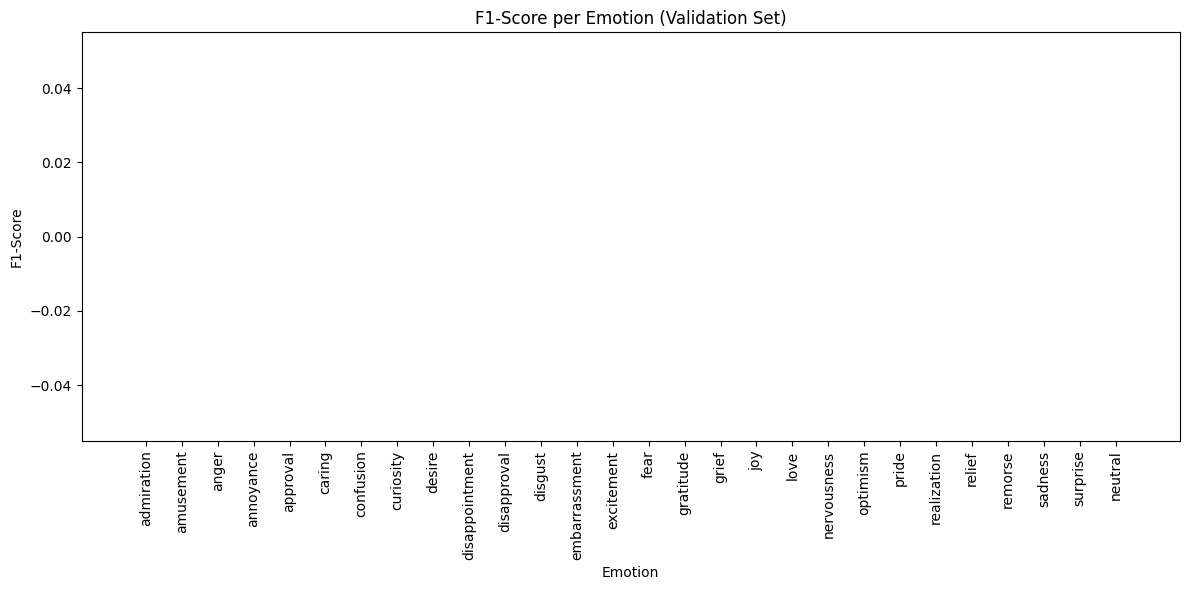


DIAGNOSIS: Semua metrics 0.0000 mungkin karena:
1. Threshold terlalu tinggi (default 0.5)
2. Model tidak belajar dengan baik
3. Labels format tidak sesuai

Coba evaluasi dengan threshold berbeda...

Testing different thresholds:


Evaluating (threshold=0.1): 100%|██████████| 170/170 [02:39<00:00,  1.07it/s]



Threshold 0.1:
  Accuracy: 0.0000
  Precision: 0.1103
  Recall: 0.5649
  F1-Score: 0.1737


Evaluating (threshold=0.2): 100%|██████████| 170/170 [02:38<00:00,  1.07it/s]



Threshold 0.2:
  Accuracy: 0.2934
  Precision: 0.0901
  Recall: 0.2768
  F1-Score: 0.1359


Evaluating (threshold=0.3): 100%|██████████| 170/170 [02:38<00:00,  1.07it/s]



Threshold 0.3:
  Accuracy: 0.2934
  Precision: 0.0901
  Recall: 0.2768
  F1-Score: 0.1359


Evaluating (threshold=0.4): 100%|██████████| 170/170 [02:38<00:00,  1.07it/s]



Threshold 0.4:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


Evaluating (threshold=0.5): 100%|██████████| 170/170 [02:43<00:00,  1.04it/s]


Threshold 0.5:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


In [19]:
print("Evaluating on validation set...")
val_metrics = trainer.evaluate(val_dataset)
print("\nValidation Metrics:")

# Format metrics yang numerik
for key, value in val_metrics.items():
    if key != 'per_class' and key != 'eval_per_class':
        # Cek apakah value bisa diformat sebagai float
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# %%
# Evaluasi pada test set
print("\nEvaluating on test set...")
test_metrics = trainer.evaluate(test_dataset)
print("\nTest Metrics:")

for key, value in test_metrics.items():
    if key != 'per_class' and key != 'eval_per_class':
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# %%
# Visualisasi per-class metrics untuk validation set
# Cek apakah ada per_class metrics dengan nama yang berbeda
per_class_key = None
for key in val_metrics.keys():
    if 'per_class' in key or 'class' in key:
        per_class_key = key
        break

if per_class_key and isinstance(val_metrics[per_class_key], dict):
    per_class_data = val_metrics[per_class_key]
    
    # Buat DataFrame untuk per-class metrics
    try:
        per_class_df = pd.DataFrame(per_class_data).T
        per_class_df['emotion'] = per_class_df.index
        
        # Plot F1-score per class
        plt.figure(figsize=(12, 6))
        
        # Pastikan kolom 'f1' ada
        if 'f1' in per_class_df.columns:
            per_class_df = per_class_df.sort_values('f1', ascending=False)
            plt.bar(range(len(per_class_df)), per_class_df['f1'])
            plt.xticks(range(len(per_class_df)), per_class_df['emotion'], rotation=90)
            plt.xlabel('Emotion')
            plt.ylabel('F1-Score')
            plt.title('F1-Score per Emotion (Validation Set)')
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak ada kolom 'f1' dalam per_class metrics")
            
    except Exception as e:
        print(f"Error visualisasi per-class metrics: {e}")

# Alternatif: Jika metrics 0 semua, mungkin ada masalah dengan threshold
print("\n" + "="*60)
print("DIAGNOSIS: Semua metrics 0.0000 mungkin karena:")
print("1. Threshold terlalu tinggi (default 0.5)")
print("2. Model tidak belajar dengan baik")
print("3. Labels format tidak sesuai")
print("="*60)

# Coba evaluasi manual dengan threshold berbeda
print("\nCoba evaluasi dengan threshold berbeda...")

def evaluate_with_threshold(model, dataset, threshold=0.3):
    """Evaluasi manual dengan threshold yang bisa diatur"""
    from torch.utils.data import DataLoader
    
    model.eval()
    all_preds = []
    all_labels = []
    
    # Buat DataLoader sederhana
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda x: {
            'input_ids': torch.stack([item['input_ids'] for item in x]),
            'attention_mask': torch.stack([item['attention_mask'] for item in x]),
            'labels': torch.stack([item['labels'] for item in x]).float()
        }
    )
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating (threshold={threshold})"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            
            # Get predictions dengan threshold tertentu
            sigmoid = torch.nn.Sigmoid()
            probs = sigmoid(outputs.logits)
            preds = (probs >= threshold).int().cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Hitung metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'threshold': threshold
    }

# Coba beberapa threshold
print("\nTesting different thresholds:")
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

for thresh in thresholds:
    metrics = evaluate_with_threshold(model, val_dataset, threshold=thresh)
    print(f"\nThreshold {thresh}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")

# ## 9. Inference dan Testing

In [20]:
def predict_emotion(text, model, tokenizer, threshold=0.5):
    # Tokenisasi input
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="pt"
    )
    
    # Pindahkan ke device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Apply sigmoid
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits)
    
    # Ambil predictions berdasarkan threshold
    predictions = (probs >= threshold).cpu().numpy()[0]
    
    # Dapatkan label yang diprediksi
    predicted_labels = [emotion_labels[i] for i in range(len(predictions)) if predictions[i] == 1]
    predicted_probs = {emotion_labels[i]: float(probs[0][i]) for i in range(len(emotion_labels))}
    
    return predicted_labels, predicted_probs

# %%
# Test dengan contoh teks
test_texts = [
    "I'm so happy and excited about this amazing news!",
    "This is really frustrating and annoying, I can't believe it.",
    "I feel grateful for all the support I received.",
    "This situation makes me nervous and fearful about the future."
]

print("Testing model predictions:")
print("=" * 60)
for text in test_texts:
    predicted_labels, predicted_probs = predict_emotion(text, model, tokenizer)
    
    print(f"\nText: {text}")
    print(f"Predicted emotions: {predicted_labels}")
    
    # Tampilkan top 3 probabilities
    sorted_probs = sorted(predicted_probs.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 probabilities:")
    for emotion, prob in sorted_probs:
        print(f"  {emotion}: {prob:.3f}")
    print("-" * 60)


Testing model predictions:

Text: I'm so happy and excited about this amazing news!
Predicted emotions: []
Top 3 probabilities:
  neutral: 0.340
  admiration: 0.122
  amusement: 0.118
------------------------------------------------------------

Text: This is really frustrating and annoying, I can't believe it.
Predicted emotions: []
Top 3 probabilities:
  neutral: 0.344
  admiration: 0.122
  amusement: 0.118
------------------------------------------------------------

Text: I feel grateful for all the support I received.
Predicted emotions: []
Top 3 probabilities:
  neutral: 0.346
  admiration: 0.120
  amusement: 0.119
------------------------------------------------------------

Text: This situation makes me nervous and fearful about the future.
Predicted emotions: []
Top 3 probabilities:
  neutral: 0.344
  admiration: 0.122
  amusement: 0.119
------------------------------------------------------------


# ## 10. Analisis Hasil

Generating predictions for entire test set...
Classification Report (micro average):
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00       504
     amusement       0.00      0.00      0.00       264
         anger       0.00      0.00      0.00       198
     annoyance       0.00      0.00      0.00       320
      approval       0.00      0.00      0.00       351
        caring       0.00      0.00      0.00       135
     confusion       0.00      0.00      0.00       153
     curiosity       0.00      0.00      0.00       284
        desire       0.00      0.00      0.00        83
disappointment       0.00      0.00      0.00       151
   disapproval       0.00      0.00      0.00       267
       disgust       0.00      0.00      0.00       123
 embarrassment       0.00      0.00      0.00        37
    excitement       0.00      0.00      0.00       103
          fear       0.00      0.00      0.00        78
     gratitude    

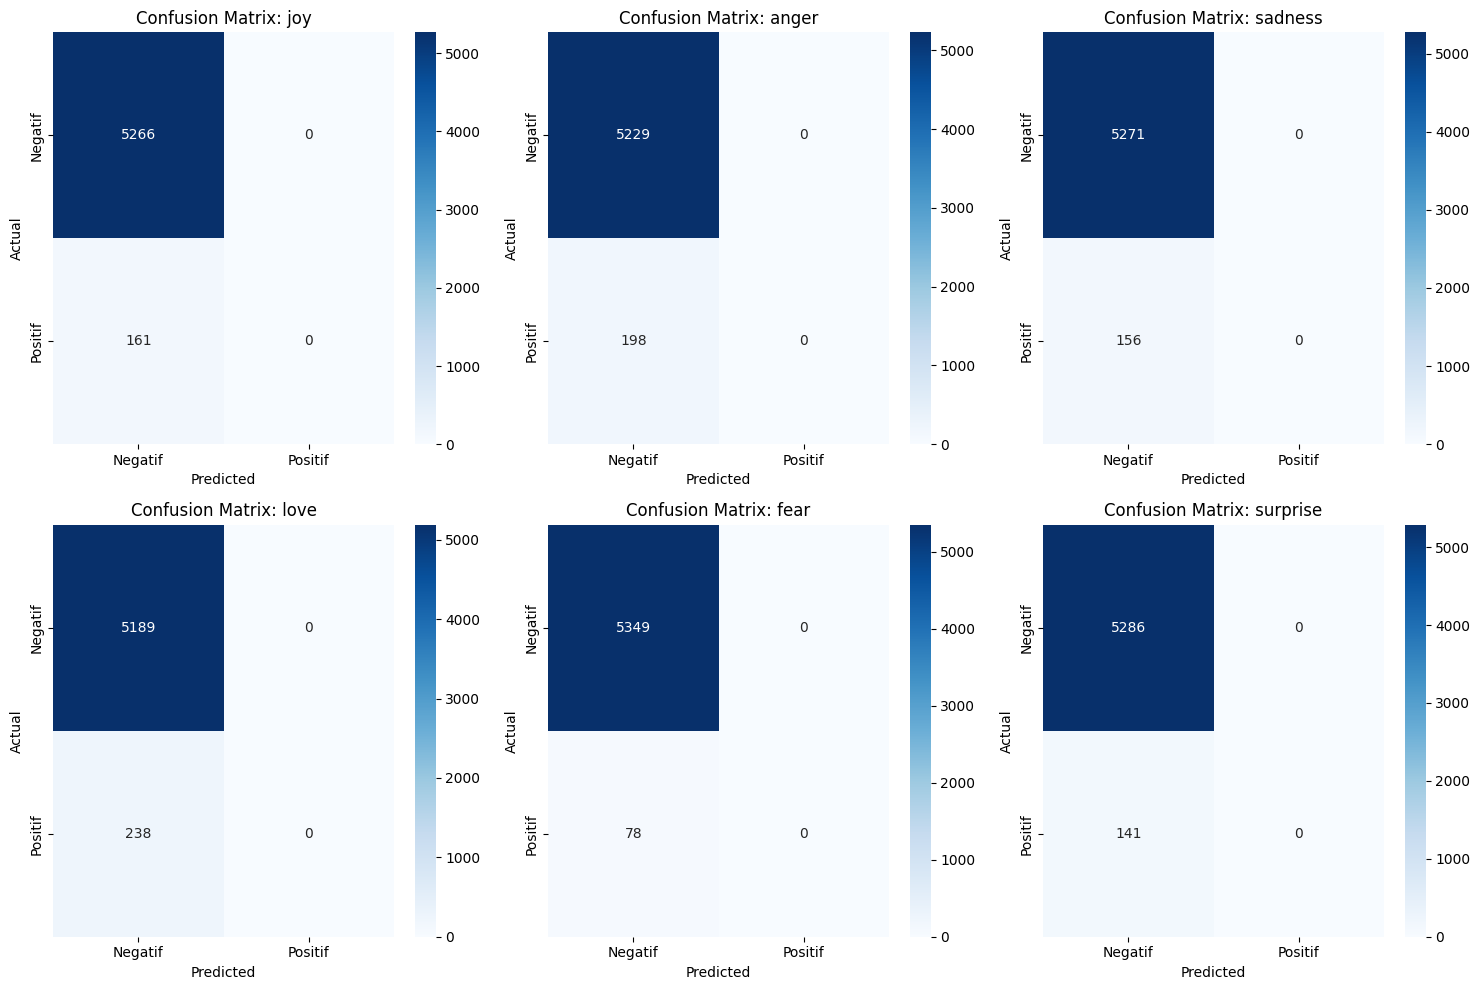

In [21]:
print("Generating predictions for entire test set...")
test_predictions = trainer.predict(test_dataset)

# %%
# Extract predictions dan labels
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(test_predictions.predictions))
threshold = 0.5
y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= threshold)] = 1
y_true = test_predictions.label_ids

# %%
# Classification report
print("Classification Report (micro average):")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=emotion_labels,
    zero_division=0
))

# %%
# Hitung confusion matrix untuk beberapa label utama
main_emotions = ['joy', 'anger', 'sadness', 'love', 'fear', 'surprise']
main_indices = [emotion_labels.index(e) for e in main_emotions]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (emotion, ax) in enumerate(zip(main_emotions, axes)):
    cm = multilabel_confusion_matrix(y_true, y_pred)[main_indices[idx]]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Negatif', 'Positif'],
                yticklabels=['Negatif', 'Positif'])
    ax.set_title(f'Confusion Matrix: {emotion}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


# ## 11. Error Analysis

In [22]:
def find_misclassified_examples(y_true, y_pred, dataset, num_examples=5):
    misclassified = []
    
    for i in range(len(y_true)):
        if not np.array_equal(y_true[i], y_pred[i]):
            # Hitung jumlah label yang berbeda
            diff = np.sum(y_true[i] != y_pred[i])
            
            # Ambil teks asli
            original_text = dataset['test'][i]['text']
            original_labels = [emotion_labels[idx] for idx in dataset['test'][i]['labels'] if idx < len(emotion_labels)]
            
            # Predicted labels
            predicted_labels = [emotion_labels[idx] for idx in range(len(y_pred[i])) if y_pred[i][idx] == 1]
            
            misclassified.append({
                'text': original_text,
                'true_labels': original_labels,
                'pred_labels': predicted_labels,
                'diff_count': diff
            })
            
            if len(misclassified) >= num_examples:
                break
    
    return misclassified

# %%
# Tampilkan contoh misclassified
print("Misclassified Examples:")
print("=" * 80)
misclassified = find_misclassified_examples(y_true, y_pred, dataset, 5)

for i, example in enumerate(misclassified, 1):
    print(f"\nExample {i}:")
    print(f"Text: {example['text']}")
    print(f"True labels: {example['true_labels']}")
    print(f"Predicted labels: {example['pred_labels']}")
    print(f"Number of label differences: {example['diff_count']}")
    print("-" * 80)

Misclassified Examples:

Example 1:
Text: I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
True labels: ['sadness']
Predicted labels: []
Number of label differences: 1
--------------------------------------------------------------------------------

Example 2:
Text: It's wonderful because it's awful. At not with.
True labels: ['admiration']
Predicted labels: []
Number of label differences: 1
--------------------------------------------------------------------------------

Example 3:
Text: Kings fan here, good luck to you guys! Will be an interesting game to watch! 
True labels: ['excitement']
Predicted labels: []
Number of label differences: 1
--------------------------------------------------------------------------------

Example 4:
Text: I didn't know that, thank you for teaching me something today!
True labels: ['gratitude']
Predicted labels: []
Number of label differences: 1
--------------------------------------------------------

# ## 12. Save Final Report

In [24]:
report = f"""
# BERT Emotion Classification - Final Report
## Dataset: Go Emotions
## Model: bert-base-uncased

## Performance Summary:
- **Accuracy**: {test_metrics.get('eval_accuracy', 0):.4f}
- **Precision**: {test_metrics.get('eval_precision', 0):.4f}
- **Recall**: {test_metrics.get('eval_recall', 0):.4f}
- **F1-Score**: {test_metrics.get('eval_f1', 0):.4f}
- **Subset Accuracy**: {test_metrics.get('eval_subset_accuracy', 0):.4f}

## Training Details:
- Epochs: 3
- Batch Size: 16 (train), 32 (eval)
- Learning Rate: 5e-5
- Max Sequence Length: 128

## Best Model Saved at: ./bert-go-emotions-final
"""

print(report)

# Save report to file
with open("bert_emotion_classification_report.md", "w") as f:
    f.write(report)

print("Report saved to 'bert_emotion_classification_report.md'")


# BERT Emotion Classification - Final Report
## Dataset: Go Emotions
## Model: bert-base-uncased

## Performance Summary:
- **Accuracy**: 0.0000
- **Precision**: 0.0000
- **Recall**: 0.0000
- **F1-Score**: 0.0000
- **Subset Accuracy**: 0.0000

## Training Details:
- Epochs: 3
- Batch Size: 16 (train), 32 (eval)
- Learning Rate: 5e-5
- Max Sequence Length: 128

## Best Model Saved at: ./bert-go-emotions-final

Report saved to 'bert_emotion_classification_report.md'


# ## 13. Deployment Preparation

In [25]:
inference_script = """
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

class EmotionClassifier:
    def __init__(self, model_path="./bert-go-emotions-final"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        
        self.emotion_labels = [
            'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
            'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
            'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
            'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
            'relief', 'remorse', 'sadness', 'surprise', 'neutral'
        ]
    
    def predict(self, text, threshold=0.5):
        # Tokenize
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors="pt"
        )
        
        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
        
        # Apply sigmoid
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Get predictions
        predicted_indices = np.where(probs >= threshold)[0]
        predicted_emotions = [self.emotion_labels[i] for i in predicted_indices]
        confidence_scores = {self.emotion_labels[i]: float(probs[i]) for i in range(len(self.emotion_labels))}
        
        return predicted_emotions, confidence_scores

# Usage example
if __name__ == "__main__":
    classifier = EmotionClassifier()
    text = "I'm really happy about this wonderful news!"
    emotions, scores = classifier.predict(text)
    print(f"Text: {text}")
    print(f"Predicted emotions: {emotions}")
    print("Top 3 confidence scores:")
    for emotion, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {emotion}: {score:.3f}")
"""

# Save inference script
with open("emotion_classifier.py", "w") as f:
    f.write(inference_script)

print("Inference script saved to 'emotion_classifier.py'")


Inference script saved to 'emotion_classifier.py'


# ## 14. Requirements File

In [26]:
requirements = """torch>=2.0.0
transformers>=4.30.0
datasets>=2.12.0
evaluate>=0.4.0
scikit-learn>=1.2.0
numpy>=1.24.0
pandas>=1.5.0
matplotlib>=3.7.0
seaborn>=0.12.0
tqdm>=4.65.0
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("Requirements saved to 'requirements.txt'")

Requirements saved to 'requirements.txt'
